# 4-2 Dataset と DataLoader の実装

## マスクデータとは
ここで使用する画像データには，小さくしか写っていない，単純にアノテーションデータがないだけなどの理由で，人が写っているのに姿勢情報のアノテーションが存在しないデータもある．
こうしたデータは姿勢推定の学習に悪影響を及ぼす．  
そこで，画像中に写ってはいるがアノテーションのない人物に関しては黒く塗りつぶすマスクをかけておく．
これをマスクデータと呼ぶ．
OpenPose の学習時には損失関数の計算時に，画像から検出された座標位置に対してマスクデータを照合し，マスクされたピクセルに関しては損失の計算から除外する．

## フォルダの準備
毎度のように，make_folders_and_data_downloads.ipynb を実行する．

## 画像・アノテーション・マスクデータへのファイルパスリストを作成
画像データ、アノテーションデータ、マスクデータへのファイルパスリストを作成する．
画像データに関しては COCO.json に記載されている画像のみを data/val2014 から取り出して使用する．

In [1]:
import os.path as osp
import json

def make_datapath_list(rootpath):
    ''' 学習、検証の画像・アノテーション・マスクデータへのファイルパスリストを作成 '''
    
    # アノテーションの JSON ファイルの読み込み
    json_path = osp.join(rootpath, "COCO.json")
    with open(json_path) as data_file:
        data_this = json.load(data_file)
        data_json = data_this["root"]
        
    # index を格納
    num_samples = len(data_json)
    train_indices = []
    val_indices = []
    for count in range(num_samples):
        if data_json[count]["isValidation"] != 0.0:
            val_indices.append(count)
        else:
            train_indices.append(count)
            
    # 画像ファイルパスを作成
    train_img_list = list()
    val_img_list = list()
    
    for idx in train_indices:
        img_path = osp.join(rootpath, data_json[idx]["img_paths"])
        train_img_list.append(img_path)
        
    for idx in val_indices:
        img_path = osp.join(rootpath, data_json[idx]["img_paths"])
        val_img_list.append(img_path)
        
    # マスクデータのパスを格納
    train_mask_list = []
    val_mask_list = []
    
    for idx in train_indices:
        img_idx = data_json[idx]["img_paths"][-16:-4]
        anno_path = "./data/mask/train2014/mask_COCO_tarin2014_" + img_idx+'.jpg'
        train_mask_list.append(anno_path)
        
    for idx in val_indices:
        img_idx = data_json[idx]["img_paths"][-16:-4]
        anno_path = "./data/mask/val2014/mask_COCO_val2014_" + img_idx+'.jpg'
        val_mask_list.append(anno_path)
        
    # アノテーションデータを格納
    train_meta_list = list()
    val_meta_list = list()
    
    for idx in train_indices:
        train_meta_list.append(data_json[idx])
        
    for idx in val_indices:
        val_meta_list.append(data_json[idx])
        
    return train_img_list, val_img_list, train_mask_list, val_mask_list, train_meta_list, val_meta_list

In [2]:
# 動作確認
train_img_list, val_img_list, train_mask_list, val_mask_list, train_meta_list, val_meta_list = make_datapath_list(rootpath="./data/")
val_meta_list[24]

{'dataset': 'COCO_val',
 'isValidation': 1.0,
 'img_paths': 'val2014/COCO_val2014_000000000488.jpg',
 'img_width': 640.0,
 'img_height': 406.0,
 'objpos': [233.075, 275.815],
 'image_id': 488.0,
 'bbox': [180.76, 210.3, 104.63, 131.03],
 'segment_area': 4851.846,
 'num_keypoints': 15.0,
 'joint_self': [[266.0, 231.0, 1.0],
  [0.0, 0.0, 2.0],
  [264.0, 229.0, 1.0],
  [0.0, 0.0, 2.0],
  [256.0, 231.0, 1.0],
  [261.0, 239.0, 1.0],
  [238.0, 239.0, 1.0],
  [267.0, 259.0, 1.0],
  [222.0, 262.0, 1.0],
  [272.0, 267.0, 1.0],
  [243.0, 256.0, 1.0],
  [244.0, 278.0, 1.0],
  [229.0, 279.0, 1.0],
  [269.0, 297.0, 1.0],
  [219.0, 310.0, 1.0],
  [267.0, 328.0, 1.0],
  [192.0, 329.0, 1.0]],
 'scale_provided': 0.356,
 'joint_others': [[[0.0, 0.0, 2.0],
   [0.0, 0.0, 2.0],
   [0.0, 0.0, 2.0],
   [0.0, 0.0, 2.0],
   [174.0, 261.0, 1.0],
   [169.0, 275.0, 1.0],
   [155.0, 275.0, 1.0],
   [190.0, 282.0, 1.0],
   [142.0, 299.0, 1.0],
   [217.0, 285.0, 1.0],
   [133.0, 329.0, 1.0],
   [0.0, 0.0, 2.0],
   [

## マスクデータの働きを確認
マスクデータがどのように動作するか確認する．
以下のコードを実行すると遠くの人物がマスクされる．

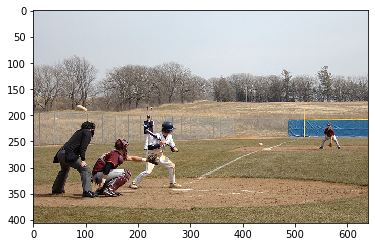

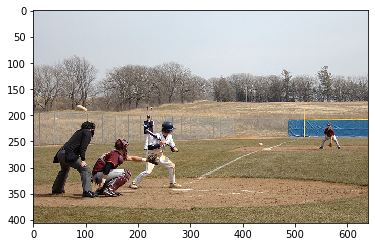

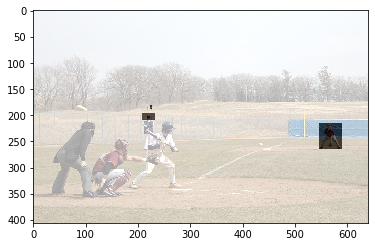

In [4]:
%matplotlib inline

import cv2
from matplotlib import pyplot as plt

index = 24

# 画像
img = cv2.imread(val_img_list[index])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

# マスク
mask_miss = cv2.imread(val_mask_list[index])
mask_miss = cv2.cvtColor(mask_miss, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

# 合成
blend_img = cv2.addWeighted(img, 0.4, mask_miss, 0.6, 8)
plt.imshow(blend_img)
plt.show()